In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, precision_recall_curve, confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import shap

In [2]:
df = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
x = df.drop(columns=['Outcome'])
y = df['Outcome']

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.35, random_state=42)

In [7]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dt',DecisionTreeClassifier(random_state=42))
])

In [8]:
def objective(trial):
    criterion = trial.suggest_categorical('criterion',{'gini','log_loss','entropy'})
    splitter = trial.suggest_categorical('splitter',{'best', 'random'})
    max_depth= trial.suggest_int('max_depth',2, 20)
    min_samples_split = trial.suggest_int('min_samples_split',2,20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf',2, 20)
    max_features= trial.suggest_categorical('max_features',{None,"sqrt","log2"})

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('dt',DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=max_depth, min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf, max_features=max_features, random_state=42))
    ])
    
    score = cross_val_score(pipeline, x_train, y_train, cv =5, scoring ='accuracy').mean()
    return score

In [9]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials =50)

best_params = study.best_params

best_model = Pipeline([
    ('scaler',StandardScaler()),
    ('dt',DecisionTreeClassifier(criterion=best_params['criterion'], splitter=best_params['splitter'], max_depth=best_params['max_depth'],
                                 min_samples_split=best_params['min_samples_split'],
                                   min_samples_leaf=best_params['min_samples_leaf'], max_features=best_params['max_features'], random_state=42))
])

[I 2025-02-14 21:08:28,938] A new study created in memory with name: no-name-a33a1201-665c-46a6-9efc-ab2fecb828de
[I 2025-02-14 21:08:29,147] Trial 0 finished with value: 0.6973333333333332 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.6973333333333332.
[I 2025-02-14 21:08:29,300] Trial 1 finished with value: 0.7655151515151515 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 17, 'min_samples_split': 12, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 1 with value: 0.7655151515151515.
[I 2025-02-14 21:08:29,443] Trial 2 finished with value: 0.7634747474747475 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 16, 'min_samples_split': 11, 'min_samples_leaf': 14, 'max_features': None}. Best is trial 1 with value: 0.7655151515151515.
[I 2025-02-14 21:08:29,580] Trial 3 finished with value: 0.6813737373

In [10]:
best_model.fit(x_train, y_train)

y_pred = best_model.predict(x_test)
print(y_pred)

[0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1
 1 0 1 0 0 1 1 0 1 1 0 0 1 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0
 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0
 0 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0 0 1 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 0 1 0 1
 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0
 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 1 0 1 0 0 1 0 1 0
 0 0 1 0 0 0 0 0 0 0]


In [11]:
proba = best_model.predict_proba(x_test)
print(proba)

[[0.58333333 0.41666667]
 [0.86956522 0.13043478]
 [0.86956522 0.13043478]
 [0.93939394 0.06060606]
 [0.71428571 0.28571429]
 [0.58333333 0.41666667]
 [1.         0.        ]
 [0.42105263 0.57894737]
 [0.58333333 0.41666667]
 [0.3030303  0.6969697 ]
 [0.58333333 0.41666667]
 [0.         1.        ]
 [0.48148148 0.51851852]
 [0.42105263 0.57894737]
 [1.         0.        ]
 [0.84210526 0.15789474]
 [0.84210526 0.15789474]
 [1.         0.        ]
 [0.3        0.7       ]
 [0.48148148 0.51851852]
 [0.3030303  0.6969697 ]
 [1.         0.        ]
 [0.58333333 0.41666667]
 [1.         0.        ]
 [0.58333333 0.41666667]
 [0.         1.        ]
 [0.86956522 0.13043478]
 [1.         0.        ]
 [0.84210526 0.15789474]
 [0.81818182 0.18181818]
 [0.10526316 0.89473684]
 [0.3030303  0.6969697 ]
 [0.10526316 0.89473684]
 [0.125      0.875     ]
 [0.42105263 0.57894737]
 [0.42105263 0.57894737]
 [0.         1.        ]
 [0.42105263 0.57894737]
 [0.93939394 0.06060606]
 [0.48148148 0.51851852]


In [ ]:
prediksi = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\diabetespredict.csv")
prediksi.head()

In [ ]:
y_prediksi = best_model.predict(prediksi)
probabilitas_prediksi = best_model.predict_proba(prediksi)
print(y_prediksi)
print(probabilitas_prediksi)

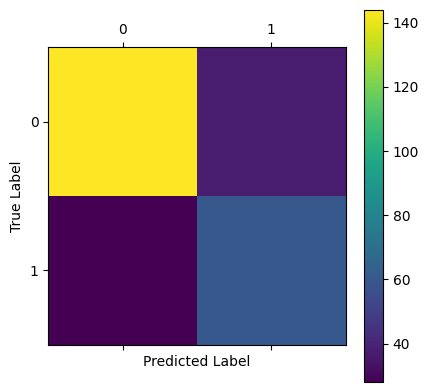

In [12]:
matrix = confusion_matrix(y_test, y_pred)

plt.matshow(matrix)
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [13]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.758364312267658

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       181
           1       0.62      0.68      0.65        88

    accuracy                           0.76       269
   macro avg       0.73      0.74      0.73       269
weighted avg       0.77      0.76      0.76       269



Text(113.9222222222222, 0.5, 'true value')

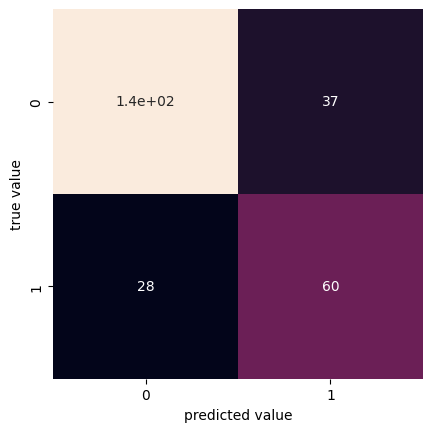

In [44]:
sns.heatmap(matrix, square  =True, annot = True, cbar = False)
plt.xlabel('predicted value')
plt.ylabel('true value')

In [45]:
cv_scores = cross_val_score(best_model, x_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

Cross-Validation Scores: [0.81       0.73       0.84       0.69       0.77777778]
Mean CV Accuracy: 0.7695555555555555


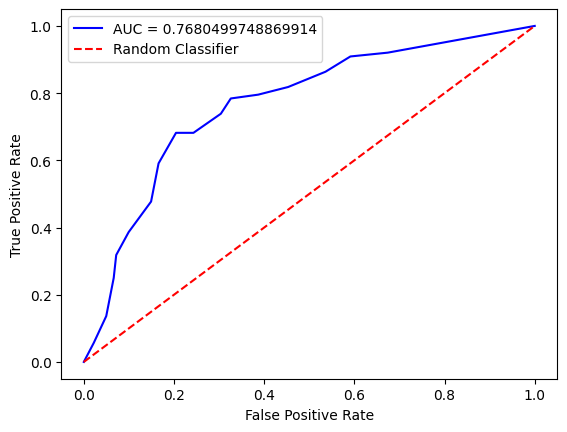

In [47]:
prob_estimate = best_model.predict_proba(x_test)

fpr, tpr, threshhold = roc_curve(y_test, prob_estimate[:,1])
nilai_auc = auc(fpr,tpr)

plt.plot(fpr, tpr,'b',label = f'AUC = {nilai_auc}')
plt.plot([0,1],[0,1], 'r--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

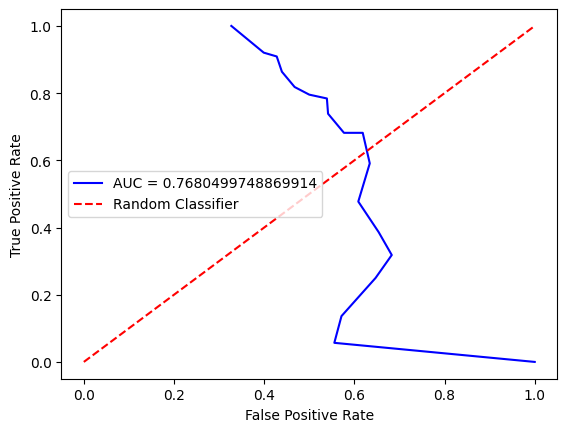

In [48]:
precision, recall, _ = precision_recall_curve(y_test, prob_estimate[:,1])
pr_auc = auc(recall,precision)

plt.plot(precision, recall,'b',label = f'AUC = {nilai_auc}')
plt.plot([0,1],[0,1], 'r--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

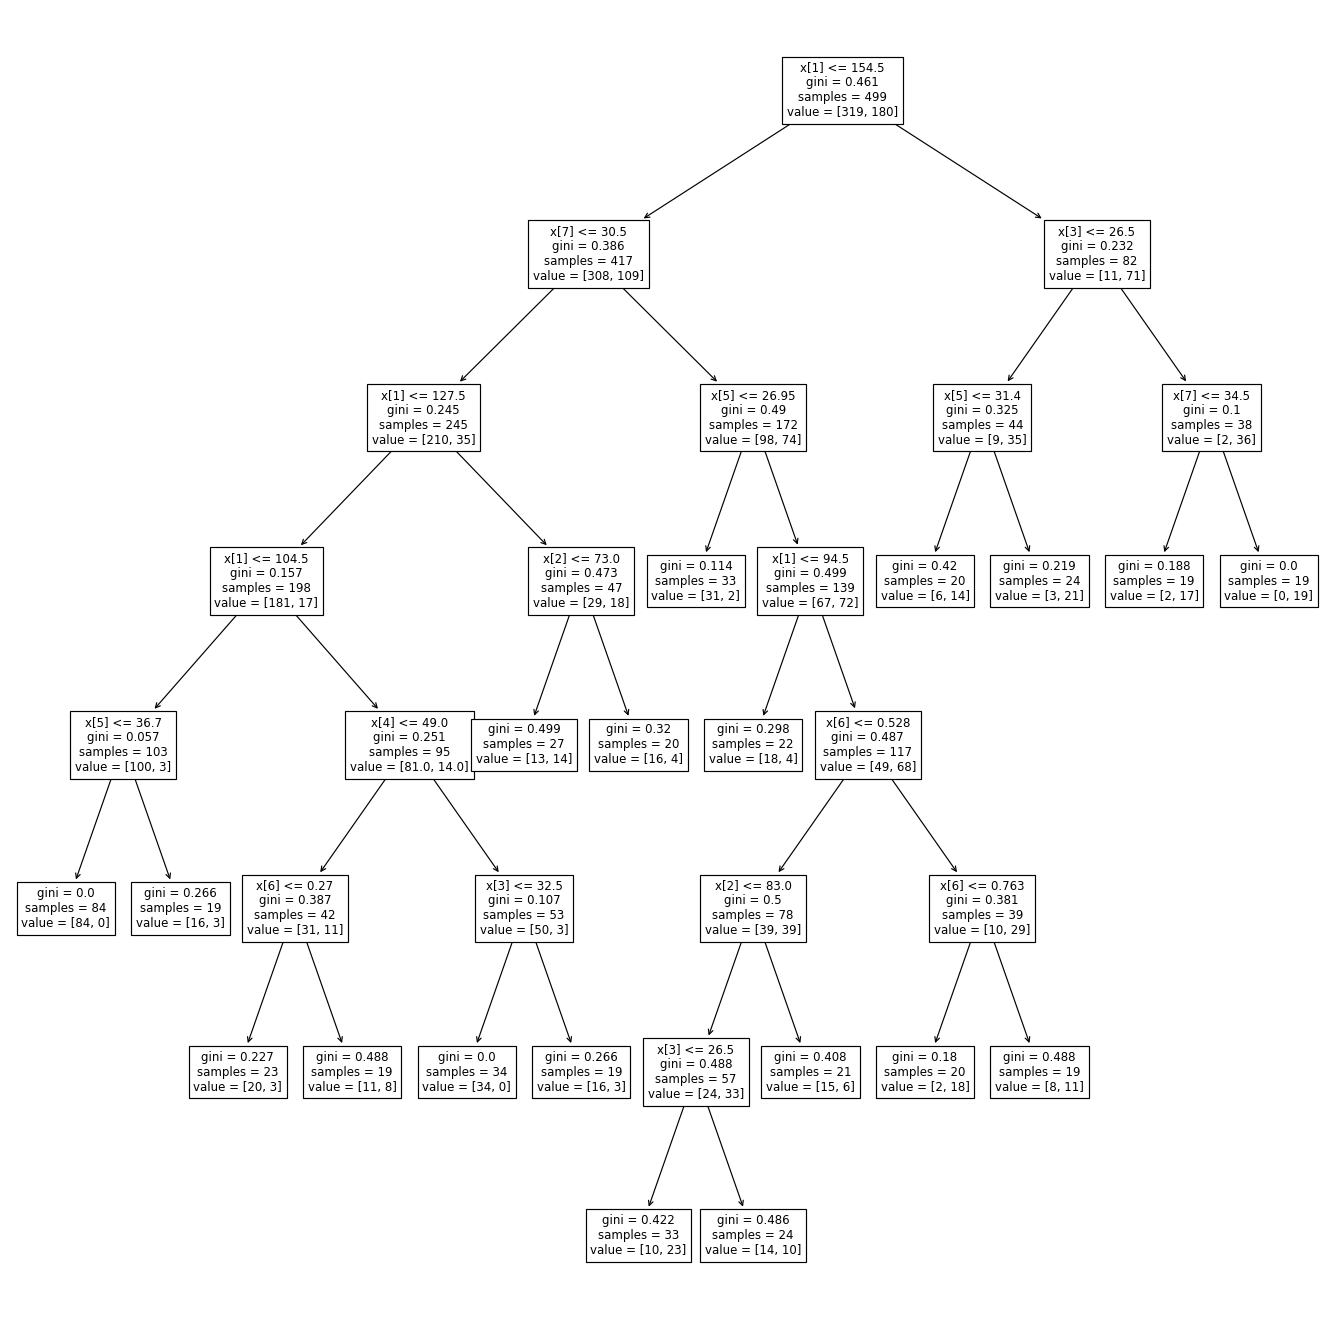

In [50]:
plt.rcParams['figure.dpi'] = 85
plt.subplots(figsize=(20,20))
tree.plot_tree(best_model, fontsize=10)
plt.show()

In [14]:
dt = best_model.named_steps['dt']
feature_importances = pd.DataFrame({
    'Feature': x.columns,
    'Importance': dt.feature_importances_
}).sort_values(by='Importance', ascending =False)

print(feature_importances)

                    Feature  Importance
1                   Glucose    0.576689
7                       Age    0.152130
5                       BMI    0.113400
6  DiabetesPedigreeFunction    0.061671
2             BloodPressure    0.044738
3             SkinThickness    0.033594
4                   Insulin    0.017779
0               Pregnancies    0.000000


C:\Users\Robyi\AppData\Local\Temp\ipykernel_6720\3486866868.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'], orient="h", palette="viridis")


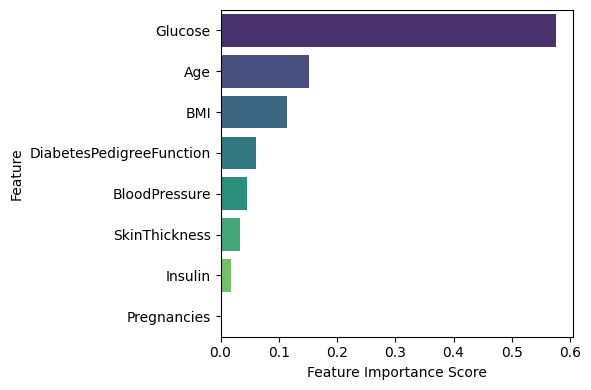

In [15]:
plt.figure(figsize=(6, 4))
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'], orient="h", palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.tight_layout()

In [18]:
explainer = shap.Explainer(best_model.predict, x_train)
shap_values = explainer(x_test)

ExactExplainer explainer: 270it [00:17, 15.05it/s]                         


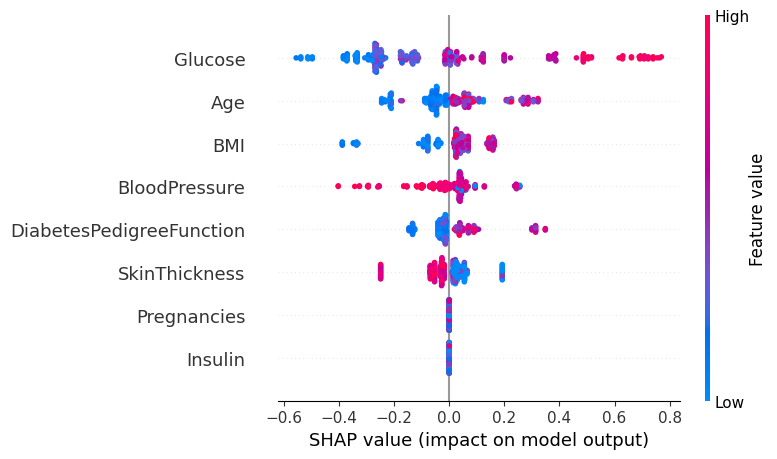

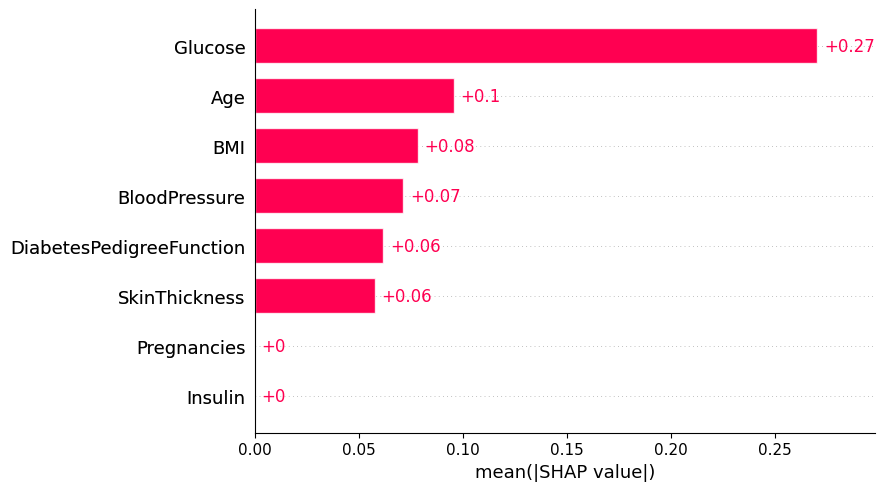

In [19]:
shap.summary_plot(shap_values, x_test, feature_names=x.columns)
shap.plots.bar(shap_values)